SHAP is available for advanced feature importance analysis
Loading and preprocessing data...
Engineering features
Preparing features and target variables.
Using 17 features for training
Features: ['literacy_rate', 'female_literacy_rate', 'male_literacy_rate', 'unemployment_rate', 'female_unemployment_rate', 'male_unemployment_rate', 'working_participation_rate', 'female_working_rate', 'internet_penetration', 'urban_ratio', 'rural_ratio', 'population_density', 'gender_ratio', 'household_size', 'dependency_ratio', 'female_participation_gap', 'literacy_gender_gap']
Poverty threshold (70th percentile): 34.46
Dataset Shape: (638, 17)
Target Distribution (Regression): count    638.000000
mean      25.370533
std       17.149189
min        0.000000
25%        9.982500
50%       23.615000
75%       38.692500
max       74.350000
Name: MPI HCR, dtype: float64
Target Distribution (Classification): MPI HCR
0    446
1    192
Name: count, dtype: int64

TRAINING OPTIMIZED MODELS 
Training optimized Gr

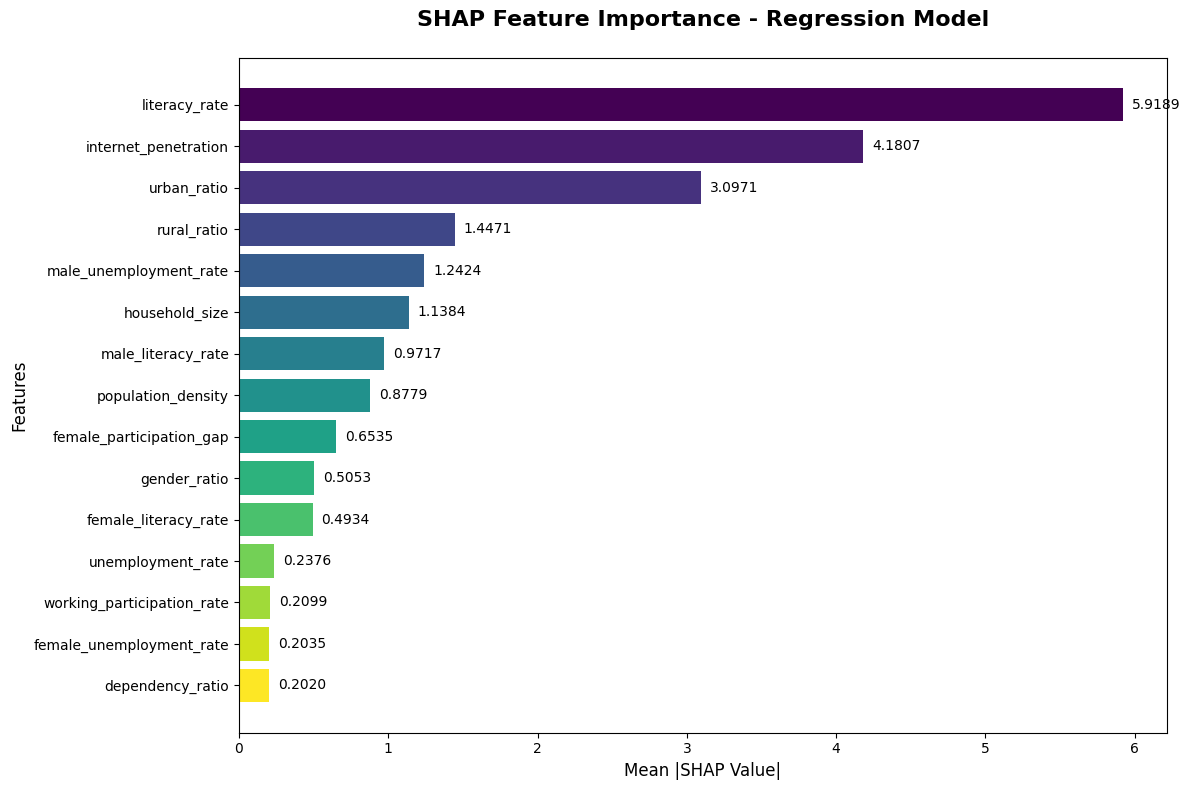

Generating SHAP summary plot for regression model...


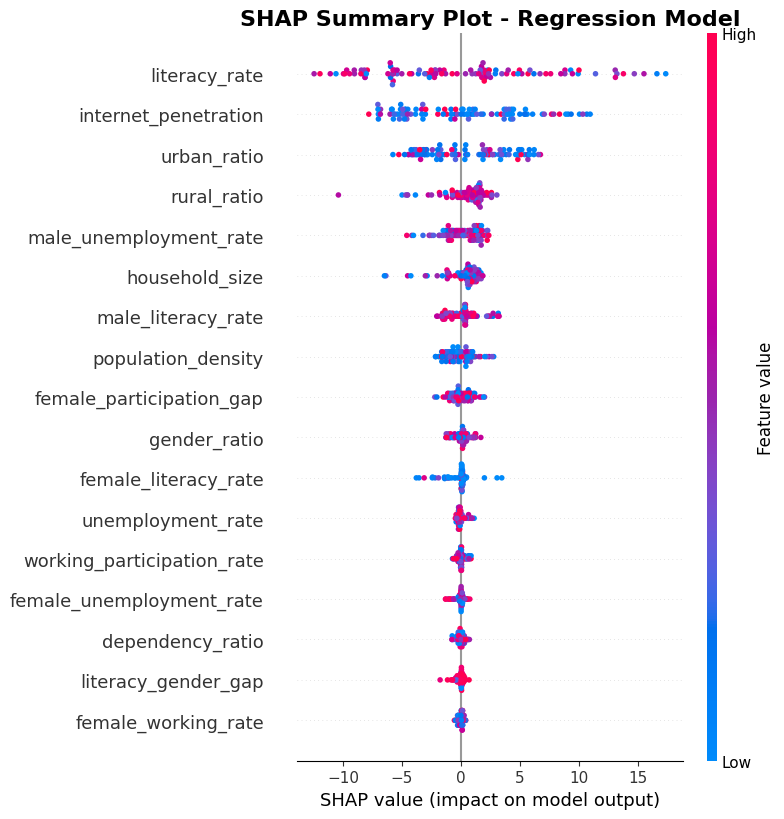


🎯 CLASSIFICATION MODEL SHAP ANALYSIS
--------------------------------------------------
Calculating SHAP feature importance for classification model...
Using 100 samples for background and 100 for explanation
Top 10 Most Important Features (SHAP - Classification):
                     feature  shap_importance  shap_importance_normalized
2         male_literacy_rate         1.408087                   30.069514
9                urban_ratio         0.886345                   18.927784
0              literacy_rate         0.577515                   12.332758
8       internet_penetration         0.567906                   12.127548
5     male_unemployment_rate         0.411563                    8.788867
10               rural_ratio         0.233219                    4.980352
15  female_participation_gap         0.102094                    2.180209
11        population_density         0.101541                    2.168393
13            household_size         0.069680                    1.4

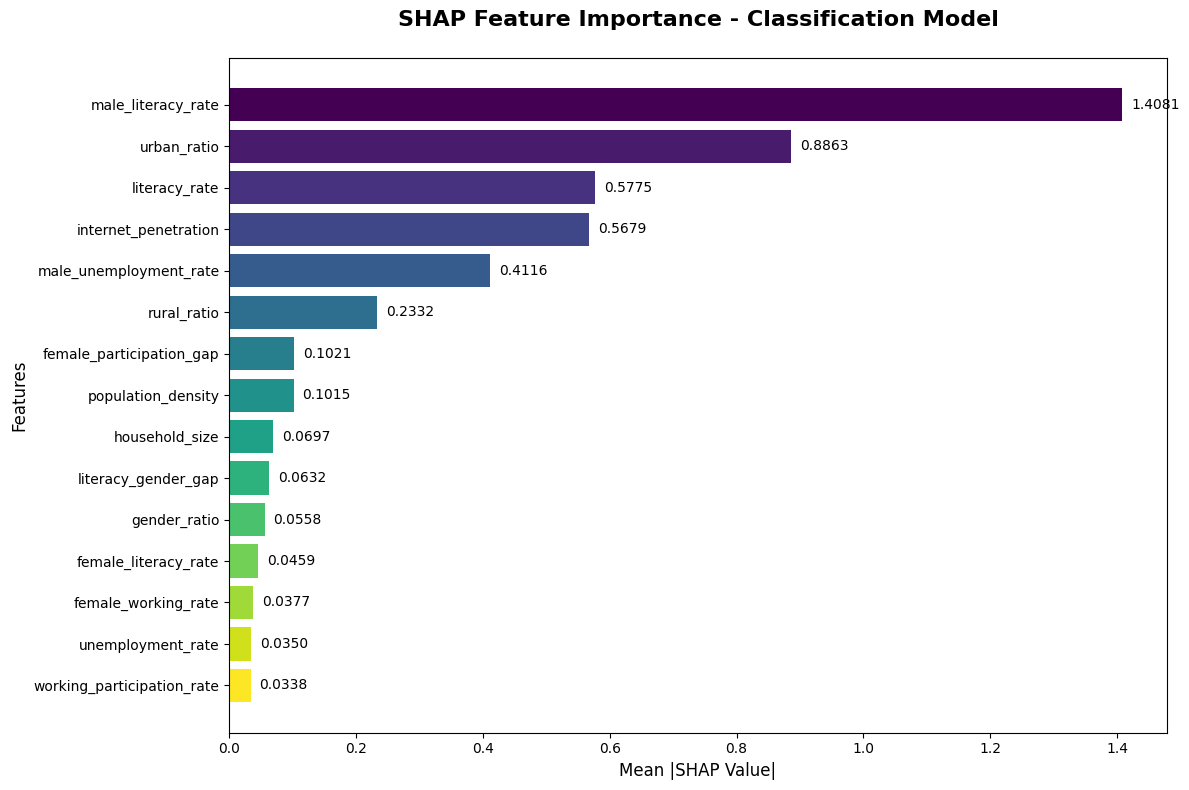

Generating SHAP summary plot for classification model...


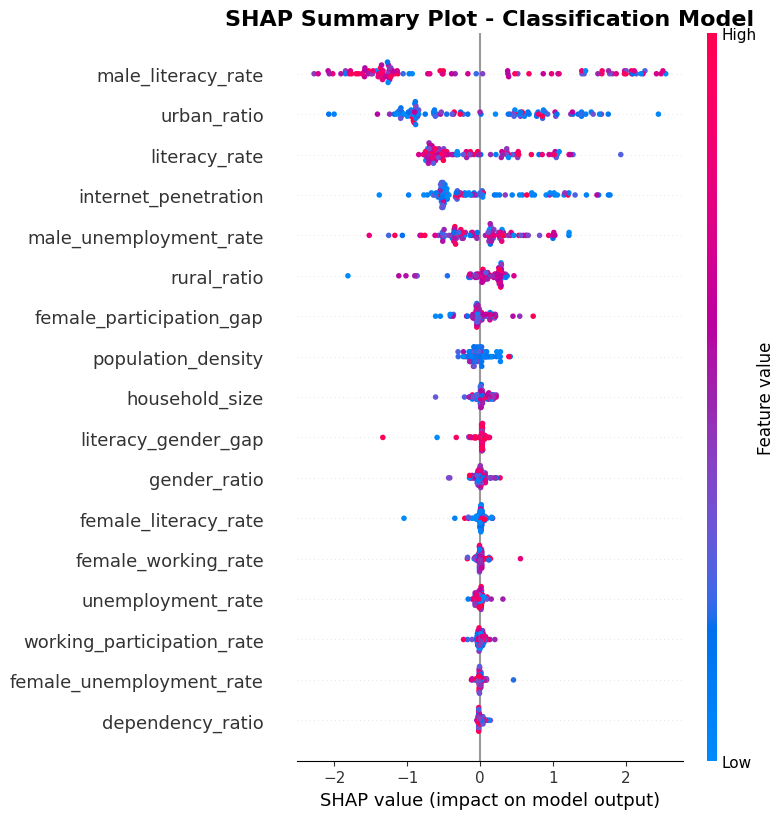

✓ SHAP feature importance saved to: models/shap_feature_importance_v2.0_20250729_163223.json

SAVING MODELS
Saving models (version v2.0)...
✓ Regression model saved to: models/poverty_regression_model_v2.0_20250729_163223.pkl
✓ Classification model saved to: models/poverty_classification_model_v2.0_20250729_163223.pkl
✓ Scaler saved to: models/scaler_v2.0_20250729_163223.pkl
✓ Metadata saved to: models/model_metadata_v2.0_20250729_163223.json

Saved files:
  regression_model: models/poverty_regression_model_v2.0_20250729_163223.pkl
  classification_model: models/poverty_classification_model_v2.0_20250729_163223.pkl
  scaler: models/scaler_v2.0_20250729_163223.pkl
  metadata: models/model_metadata_v2.0_20250729_163223.json
Creating visualizations for model results...


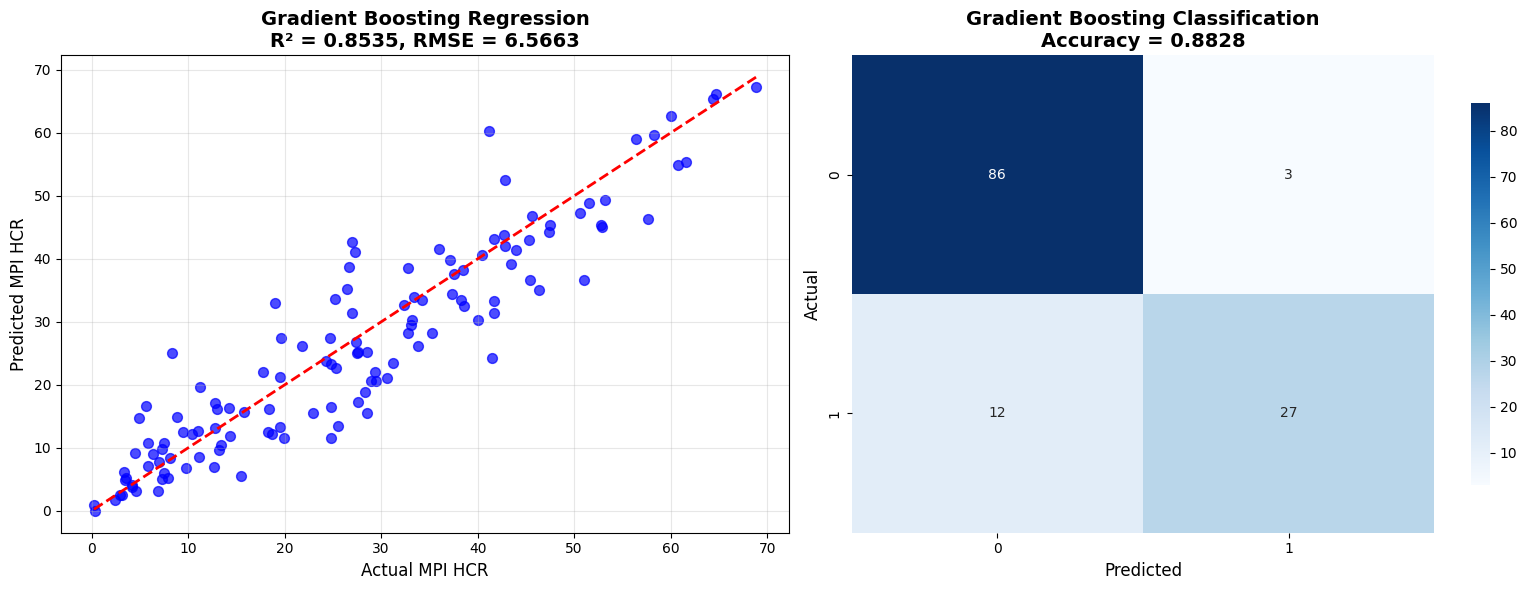


MODEL PERFORMANCE SUMMARY 

🔍 REGRESSION MODEL (Gradient Boosting)
   R² Score: 0.8535
   RMSE: 6.5663
   MSE: 43.1158

🎯 CLASSIFICATION MODEL (Gradient Boosting)
   Accuracy: 0.8828
   Precision (High-risk): 0.9000
   Recall (High-risk): 0.6923
   F1-Score (High-risk): 0.7826

📊 DATASET INFO
   Total Features: 17
   Training Set Size: 512
   Test Set Size: 128
   Features Used: literacy_rate, female_literacy_rate, male_literacy_rate, unemployment_rate, female_unemployment_rate, male_unemployment_rate, working_participation_rate, female_working_rate, internet_penetration, urban_ratio, rural_ratio, population_density, gender_ratio, household_size, dependency_ratio, female_participation_gap, literacy_gender_gap

⚠️  IMPORTANT NOTE:
   Religious and caste features have been EXCLUDED from this model
   This ensures the model focuses on socio-economic indicators only

🔬 SHAP ANALYSIS - REGRESSION
   Top 5 Important Features: literacy_rate, internet_penetration, urban_ratio, rural_ratio, ma

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import SHAP
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP is available for advanced feature importance analysis")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")
    print("Falling back to built-in feature importance")

class OptimizedPovertyAnalyzer:
    def __init__(self, model_dir='models'):
        self.scaler = StandardScaler()
        self.regression_model = None
        self.classification_model = None
        self.feature_names = []
        self.model_dir = model_dir
        self.model_metadata = {}
        self.shap_explainer_reg = None
        self.shap_explainer_clf = None
        self.shap_values_reg = None
        self.shap_values_clf = None
        self.X_train_scaled = None
        self.X_test_scaled = None

        # Create model directory if it doesn't exist
        os.makedirs(model_dir, exist_ok=True)

    def load_and_preprocess_data(self, filepath):
        """Load and preprocess the dataset"""
        print("Loading and preprocessing data...")

        # Load data
        df = pd.read_csv(filepath)

        # Clean column names
        df.columns = df.columns.str.strip()

        # Handle missing values
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        categorical_columns = df.select_dtypes(include=['object']).columns

        # Impute missing values
        numeric_imputer = SimpleImputer(strategy='median')
        df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

        return df

    def engineer_features(self, df):
        """Create engineered features for better prediction """
        print("Engineering features")

        # Calculate ratios and percentages - EXCLUDING religious and caste features
        df['literacy_rate'] = df['Literate Population'] / df['Total Population'] * 100
        df['female_literacy_rate'] = df['Literate Females'] / df['Total Females'] * 100
        df['male_literacy_rate'] = df['Literate Males'] / df['Total Males'] * 100
        df['unemployment_rate'] = df['Unemployed Population'] / df['Total Population'] * 100
        df['female_unemployment_rate'] = df['Unemployed Females'] / df['Total Females'] * 100
        df['male_unemployment_rate'] = df['Unemployed Males'] / df['Total Males'] * 100
        df['working_participation_rate'] = df['Total Working Population'] / df['Total Population'] * 100
        df['female_working_rate'] = df['Total Working Females'] / df['Total Females'] * 100
        df['internet_penetration'] = df['Households_with_Internet'] / df['Households'] * 100
        df['urban_ratio'] = df['Urban_Households'] / df['Households'] * 100
        df['rural_ratio'] = df['Rural_Households'] / df['Households'] * 100
        df['population_density'] = df['Total Population'] / df['Area (sq km)']
        df['gender_ratio'] = df['Total Females'] / df['Total Males'] * 1000
        df['household_size'] = df['Total Population'] / df['Households']

        # Additional economic and demographic features
        df['dependency_ratio'] = (df['Total Population'] - df['Total Working Population']) / df['Total Working Population'] * 100
        df['female_participation_gap'] = df['male_unemployment_rate'] - df['female_unemployment_rate']
        df['literacy_gender_gap'] = df['male_literacy_rate'] - df['female_literacy_rate']

        # Infrastructure and development indicators
        if 'Households_with_Electricity' in df.columns:
            df['electricity_access'] = df['Households_with_Electricity'] / df['Households'] * 100
        if 'Households_with_Drinking_Water' in df.columns:
            df['water_access'] = df['Households_with_Drinking_Water'] / df['Households'] * 100
        if 'Households_with_Toilet' in df.columns:
            df['sanitation_access'] = df['Households_with_Toilet'] / df['Households'] * 100

        return df

    def prepare_features_target(self, df):
        """Prepare features and target variables """
        print("Preparing features and target variables.")

        # Select relevant features - EXCLUDING religious and caste features
        feature_cols = [
            'literacy_rate', 'female_literacy_rate', 'male_literacy_rate',
            'unemployment_rate', 'female_unemployment_rate', 'male_unemployment_rate',
            'working_participation_rate', 'female_working_rate',
            'internet_penetration', 'urban_ratio', 'rural_ratio',
            'population_density', 'gender_ratio', 'household_size',
            'dependency_ratio', 'female_participation_gap', 'literacy_gender_gap'
        ]

        # Add infrastructure features if they exist
        potential_features = ['electricity_access', 'water_access', 'sanitation_access']
        for feature in potential_features:
            if feature in df.columns:
                feature_cols.append(feature)

        # Handle missing engineered features
        available_features = []
        for col in feature_cols:
            if col not in df.columns:
                print(f"Warning: {col} not found in dataset")
                continue
            if not df[col].isna().all():
                available_features.append(col)

        print(f"Using {len(available_features)} features for training")
        print(f"Features: {available_features}")

        X = df[available_features].copy()

        # Handle any remaining NaN values
        X = X.fillna(X.median())

        # Target variable (MPI HCR - Multidimensional Poverty Index Headcount Ratio)
        if df['MPI HCR'].dtype == 'object':
            y_regression = pd.to_numeric(df['MPI HCR'].str.replace('%', ''), errors='coerce')
        else:
            y_regression = pd.to_numeric(df['MPI HCR'], errors='coerce')

        # Remove any NaN values that resulted from conversion
        valid_indices = ~y_regression.isna()
        X = X[valid_indices]
        y_regression = y_regression[valid_indices]

        # Create classification target (High-risk areas)
        y_regression_clean = y_regression.dropna()
        if len(y_regression_clean) > 0:
            poverty_threshold = y_regression_clean.quantile(0.7)
            print(f"Poverty threshold (70th percentile): {poverty_threshold:.2f}")
            y_classification = (y_regression >= poverty_threshold).astype(int)
            y_classification = y_classification[valid_indices]
        else:
            print("Error: No valid poverty data found")
            return None, None, None

        self.feature_names = available_features

        return X, y_regression, y_classification

    def train_optimized_regression_model(self, X, y):
        """Train and optimize Gradient Boosting Regression model"""
        print("Training optimized Gradient Boosting Regression model...")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(X_train)
        self.X_test_scaled = self.scaler.transform(X_test)

        # Start with a good baseline model
        print("Training baseline model...")
        baseline_model = GradientBoostingRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        )
        baseline_model.fit(self.X_train_scaled, y_train)
        baseline_pred = baseline_model.predict(self.X_test_scaled)
        baseline_r2 = r2_score(y_test, baseline_pred)
        print(f"Baseline R²: {baseline_r2:.4f}")

        # Reduced hyperparameter grid for faster tuning
        gb_params = {
            'n_estimators': [100, 200],
            'max_depth': [4, 5, 6],
            'learning_rate': [0.05, 0.1, 0.15],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4]
        }

        gb_model = GradientBoostingRegressor(random_state=42)
        gb_grid = GridSearchCV(
            gb_model,
            gb_params,
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

        print(f"Performing hyperparameter tuning...")
        gb_grid.fit(self.X_train_scaled, y_train)

        # Best model
        self.regression_model = gb_grid.best_estimator_

        # Make predictions
        y_pred = self.regression_model.predict(self.X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)

        print(f"Best Gradient Boosting Regression Results:")
        print(f"  Best parameters: {gb_grid.best_params_}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement over baseline: {r2 - baseline_r2:.4f}")

        # Store metadata
        self.model_metadata['regression'] = {
            'model_type': 'GradientBoostingRegressor',
            'best_params': gb_grid.best_params_,
            'performance': {
                'rmse': rmse,
                'r2': r2,
                'mse': mse
            },
            'training_date': datetime.now().isoformat(),
            'feature_names': self.feature_names,
            'excludes_religious_caste_features': True
        }

        return {
            'model': self.regression_model,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'X_test': self.X_test_scaled,
            'y_test': y_test,
            'X_train': self.X_train_scaled,
            'y_train': y_train
        }

    def train_optimized_classification_model(self, X, y):
        """Train and optimize Gradient Boosting Classification model"""
        print("Training optimized Gradient Boosting Classification model...")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Use the same scaler fitted on regression data
        X_train_scaled = self.scaler.transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Start with a good baseline model
        print("Training baseline model...")
        baseline_model = GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        )
        baseline_model.fit(X_train_scaled, y_train)
        baseline_pred = baseline_model.predict(X_test_scaled)
        baseline_accuracy = accuracy_score(y_test, baseline_pred)
        print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

        # Reduced hyperparameter grid for faster tuning
        gb_params = {
            'n_estimators': [100, 200],
            'max_depth': [4, 5, 6],
            'learning_rate': [0.05, 0.1, 0.15],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4]
        }

        gb_model = GradientBoostingClassifier(random_state=42)
        gb_grid = GridSearchCV(
            gb_model,
            gb_params,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        print(f"Performing hyperparameter tuning...")
        gb_grid.fit(X_train_scaled, y_train)

        # Best model
        self.classification_model = gb_grid.best_estimator_

        # Make predictions
        y_pred = self.classification_model.predict(X_test_scaled)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred, output_dict=True)

        print(f"Best Gradient Boosting Classification Results:")
        print(f"  Best parameters: {gb_grid.best_params_}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Improvement over baseline: {accuracy - baseline_accuracy:.4f}")
        print(f"Classification Report:")
        print(classification_report(y_test, y_pred))

        # Store metadata
        self.model_metadata['classification'] = {
            'model_type': 'GradientBoostingClassifier',
            'best_params': gb_grid.best_params_,
            'performance': {
                'accuracy': accuracy,
                'precision': clf_report['1']['precision'],
                'recall': clf_report['1']['recall'],
                'f1_score': clf_report['1']['f1-score']
            },
            'training_date': datetime.now().isoformat(),
            'feature_names': self.feature_names,
            'excludes_religious_caste_features': True
        }

        return {
            'model': self.classification_model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'classification_report': clf_report,
            'X_test': X_test_scaled,
            'y_test': y_test,
            'X_train': X_train_scaled,
            'y_train': y_train
        }

    def calculate_shap_importance(self, model_type='regression', sample_size=100):
        """Calculate SHAP feature importance for global interpretability"""
        print(f"Calculating SHAP feature importance for {model_type} model...")

        if not SHAP_AVAILABLE:
            print("SHAP not available. Please install SHAP: pip install shap")
            return self.feature_importance_analysis(model_type)

        try:
            model = self.regression_model if model_type == 'regression' else self.classification_model

            if model is None:
                print(f"{model_type.title()} model not trained yet!")
                return None

            # Use a sample of training data for SHAP explainer (for computational efficiency)
            if self.X_train_scaled is not None:
                # Sample data for background
                if len(self.X_train_scaled) > sample_size:
                    background_indices = np.random.choice(len(self.X_train_scaled), sample_size, replace=False)
                    background_data = self.X_train_scaled[background_indices]
                else:
                    background_data = self.X_train_scaled

                # Sample test data for explanation
                if len(self.X_test_scaled) > sample_size:
                    explain_indices = np.random.choice(len(self.X_test_scaled), sample_size, replace=False)
                    explain_data = self.X_test_scaled[explain_indices]
                else:
                    explain_data = self.X_test_scaled

                print(f"Using {len(background_data)} samples for background and {len(explain_data)} for explanation")

                # Create SHAP explainer
                if model_type == 'regression':
                    self.shap_explainer_reg = shap.Explainer(model, background_data)
                    self.shap_values_reg = self.shap_explainer_reg(explain_data)
                    shap_values = self.shap_values_reg
                else:
                    self.shap_explainer_clf = shap.Explainer(model, background_data)
                    self.shap_values_clf = self.shap_explainer_clf(explain_data)
                    shap_values = self.shap_values_clf

                # Calculate global feature importance (mean absolute SHAP values)
                if hasattr(shap_values, 'values'):
                    if model_type == 'classification' and len(shap_values.values.shape) == 3:
                        # For binary classification, take the positive class (class 1)
                        importance_values = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
                    else:
                        importance_values = np.abs(shap_values.values).mean(axis=0)
                else:
                    importance_values = np.abs(shap_values).mean(axis=0)

                # Create importance DataFrame
                importance_df = pd.DataFrame({
                    'feature': self.feature_names,
                    'shap_importance': importance_values,
                    'shap_importance_normalized': importance_values / importance_values.sum() * 100
                }).sort_values('shap_importance', ascending=False)

                print(f"Top 10 Most Important Features (SHAP - {model_type.title()}):")
                print(importance_df.head(10))

                # Store SHAP results in metadata
                shap_results = {
                    'feature_importance': importance_df.to_dict('records'),
                    'top_5_features': importance_df.head(5)['feature'].tolist(),
                    'method': 'SHAP',
                    'sample_size': len(explain_data),
                    'background_size': len(background_data),
                    'calculation_date': datetime.now().isoformat()
                }

                if model_type not in self.model_metadata:
                    self.model_metadata[model_type] = {}
                self.model_metadata[model_type]['shap_analysis'] = shap_results

                # Plot SHAP feature importance
                self.plot_shap_importance(importance_df, model_type)

                return importance_df

            else:
                print("No training data available for SHAP analysis. Please train the model first.")
                return None

        except Exception as e:
            print(f"Error calculating SHAP importance: {str(e)}")
            print("Falling back to built-in feature importance...")
            return self.feature_importance_analysis(model_type)

    def plot_shap_importance(self, importance_df, model_type):
        """Plot SHAP feature importance"""
        plt.figure(figsize=(12, 8))

        # Plot horizontal bar chart
        top_features = importance_df.head(15)
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

        bars = plt.barh(range(len(top_features)), top_features['shap_importance'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Mean |SHAP Value|', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title(f'SHAP Feature Importance - {model_type.title()} Model\n',
                 fontsize=16, fontweight='bold')

        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, top_features['shap_importance'])):
            plt.text(value + max(top_features['shap_importance']) * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{value:.4f}', ha='left', va='center', fontsize=10)

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def generate_shap_plots(self, model_type='regression', plot_type='summary'):
        """Generate various SHAP plots for model interpretation"""
        if not SHAP_AVAILABLE:
            print("SHAP not available for advanced plotting")
            return

        shap_values = self.shap_values_reg if model_type == 'regression' else self.shap_values_clf

        if shap_values is None:
            print(f"SHAP values not calculated for {model_type} model. Run calculate_shap_importance first.")
            return

        print(f"Generating SHAP {plot_type} plot for {model_type} model...")

        try:
            if plot_type == 'summary':
                plt.figure(figsize=(12, 8))
                if model_type == 'classification' and len(shap_values.values.shape) == 3:
                    # For binary classification, show positive class
                    shap.summary_plot(shap_values.values[:, :, 1],
                                    features=self.X_test_scaled[:len(shap_values.values)],
                                    feature_names=self.feature_names,
                                    show=False)
                else:
                    shap.summary_plot(shap_values.values,
                                    features=self.X_test_scaled[:len(shap_values.values)],
                                    feature_names=self.feature_names,
                                    show=False)
                plt.title(f'SHAP Summary Plot - {model_type.title()} Model', fontsize=16, fontweight='bold')
                plt.tight_layout()
                plt.show()

            elif plot_type == 'bar':
                plt.figure(figsize=(12, 8))
                if model_type == 'classification' and len(shap_values.values.shape) == 3:
                    shap.plots.bar(shap_values[:, :, 1], show=False)
                else:
                    shap.plots.bar(shap_values, show=False)
                plt.title(f'SHAP Bar Plot - {model_type.title()} Model', fontsize=16, fontweight='bold')
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Error generating SHAP {plot_type} plot: {str(e)}")

    def save_shap_importance_json(self, filepath=None, version='v2.0'):
        """Save SHAP feature importance to JSON file"""
        if filepath is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = os.path.join(self.model_dir, f'shap_feature_importance_{version}_{timestamp}.json')

        # Extract SHAP importance data from metadata
        shap_data = {
            'metadata': {
                'version': version,
                'timestamp': datetime.now().isoformat(),
                'model_excludes_religious_caste_features': True,
                'total_features': len(self.feature_names),
                'feature_names': self.feature_names
            },
            'shap_analysis': {}
        }

        # Add regression SHAP data if available
        if 'regression' in self.model_metadata and 'shap_analysis' in self.model_metadata['regression']:
            shap_data['shap_analysis']['regression'] = self.model_metadata['regression']['shap_analysis']

        # Add classification SHAP data if available
        if 'classification' in self.model_metadata and 'shap_analysis' in self.model_metadata['classification']:
            shap_data['shap_analysis']['classification'] = self.model_metadata['classification']['shap_analysis']

        # Save to JSON
        try:
            with open(filepath, 'w') as f:
                json.dump(shap_data, f, indent=2, default=str)
            print(f"✓ SHAP feature importance saved to: {filepath}")
            return filepath
        except Exception as e:
            print(f"✗ Error saving SHAP importance: {str(e)}")
            return None

    def feature_importance_analysis(self, model_type='regression'):
        """Analyze feature importance for the trained model (fallback method)"""
        print(f"Analyzing built-in feature importance for {model_type}...")

        model = self.regression_model if model_type == 'regression' else self.classification_model

        if model and hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("Top 10 Most Important Features:")
            print(importance_df.head(10))

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
            plt.title(f'Built-in Feature Importance - Gradient Boosting {model_type.title()}\n(Excluding Religious/Caste Features)',
                     fontsize=16, fontweight='bold')
            plt.xlabel('Importance', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.tight_layout()
            plt.show()

            return importance_df
        else:
            print("Model not trained or doesn't support feature importance analysis")
            return None

    def comprehensive_shap_analysis(self, sample_size=100):
        """Perform comprehensive SHAP analysis for both models"""
        print("\n" + "="*70)
        print("COMPREHENSIVE SHAP FEATURE IMPORTANCE ANALYSIS")
        print("="*70)

        results = {}

        # Regression model SHAP analysis
        if self.regression_model is not None:
            print("\n🔍 REGRESSION MODEL SHAP ANALYSIS")
            print("-" * 50)
            reg_importance = self.calculate_shap_importance('regression', sample_size)
            if reg_importance is not None:
                results['regression'] = reg_importance

                # Generate additional SHAP plots
                self.generate_shap_plots('regression', 'summary')

        # Classification model SHAP analysis
        if self.classification_model is not None:
            print("\n🎯 CLASSIFICATION MODEL SHAP ANALYSIS")
            print("-" * 50)
            clf_importance = self.calculate_shap_importance('classification', sample_size)
            if clf_importance is not None:
                results['classification'] = clf_importance

                # Generate additional SHAP plots
                self.generate_shap_plots('classification', 'summary')

        # Save SHAP results to JSON
        json_path = self.save_shap_importance_json()
        if json_path:
            results['json_path'] = json_path

        return results

    def save_models(self, version='v2.0'):
        """Save trained models and metadata"""
        print(f"Saving models (version {version})...")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save models
        if self.regression_model:
            reg_path = os.path.join(self.model_dir, f'poverty_regression_model_{version}_{timestamp}.pkl')
            joblib.dump(self.regression_model, reg_path)
            print(f"✓ Regression model saved to: {reg_path}")

        if self.classification_model:
            clf_path = os.path.join(self.model_dir, f'poverty_classification_model_{version}_{timestamp}.pkl')
            joblib.dump(self.classification_model, clf_path)
            print(f"✓ Classification model saved to: {clf_path}")

        # Save scaler
        scaler_path = os.path.join(self.model_dir, f'scaler_{version}_{timestamp}.pkl')
        joblib.dump(self.scaler, scaler_path)
        print(f"✓ Scaler saved to: {scaler_path}")

        # Save metadata (including SHAP results)
        metadata_path = os.path.join(self.model_dir, f'model_metadata_{version}_{timestamp}.json')
        self.model_metadata['version'] = version
        self.model_metadata['timestamp'] = timestamp
        self.model_metadata['files'] = {
            'regression_model': f'poverty_regression_model_{version}_{timestamp}.pkl',
            'classification_model': f'poverty_classification_model_{version}_{timestamp}.pkl',
            'scaler': f'scaler_{version}_{timestamp}.pkl'
        }

        with open(metadata_path, 'w') as f:
            json.dump(self.model_metadata, f, indent=2, default=str)
        print(f"✓ Metadata saved to: {metadata_path}")

        return {
            'regression_model': reg_path,
            'classification_model': clf_path,
            'scaler': scaler_path,
            'metadata': metadata_path
        }

    # def load_models(self, version='latest', timestamp=None):
    #     """Load saved models"""
    #     print(f"Loading models (version {version})...")

    #     try:
    #         if version == 'latest' and timestamp is None:
    #             # Find the latest models
    #             model_files = [f for f in os.listdir(self.model_dir) if f.startswith('poverty_regression_model_')]
    #             if not model_files:
    #                 raise FileNotFoundError("No saved models found")

    #             # Get the latest timestamp
    #             timestamps = [f.split('_')[-1].replace('.pkl', '') for f in model_files]
    #             latest_timestamp = max(timestamps)
    #             timestamp = latest_timestamp

    #             # Find the version from the latest file
    #             latest_file = [f for f in model_files if latest_timestamp in f][0]
    #             version = latest_file.split('_')[3]

    #         # Load models
    #         reg_path = os.path.join(self.model_dir, f'poverty_regression_model_{version}_{timestamp}.pkl')
    #         clf_path = os.path.join(self.model_dir, f'poverty_classification_model_{version}_{timestamp}.pkl')
    #         scaler_path = os.path.join(self.model_dir, f'scaler_{version}_{timestamp}.pkl')
    #         metadata_path = os.path.join(self.model_dir, f'model_metadata_{version}_{timestamp}.json')

    #         self.regression_model = joblib.load(reg_path)
    #         self.classification_model = joblib.load(clf_path)
    #         self.scaler = joblib.load(scaler_path)

    #         # Load metadata
    #         with open(metadata_path, 'r') as f:
    #             self.model_metadata = json.load(f)

    #         self.feature_names = self.model_metadata.get('regression', {}).get('feature_names', [])

    #         print(f"✓ Models loaded successfully")
    #         print(f"  Version: {version}")
    #         print(f"  Timestamp: {timestamp}")
    #         print(f"  Features: {len(self.feature_names)}")

    #         return True

    #     except Exception as e:
    #         print(f"✗ Error loading models: {str(e)}")
    #         return False

    def predict_poverty(self, X_new, model_type='regression'):
        """Make predictions on new data using the trained models"""
        # Scale the new data using the fitted scaler
        X_new_scaled = self.scaler.transform(X_new)

        if model_type == 'regression':
            if self.regression_model is None:
                print("Regression model not trained yet!")
                return None
            return self.regression_model.predict(X_new_scaled)
        else:
            if self.classification_model is None:
                print("Classification model not trained yet!")
                return None
            return self.classification_model.predict(X_new_scaled)

    def visualize_results(self, reg_results, clf_results):
        """Visualize model results"""
        print("Creating visualizations for model results...")

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Regression plot
        axes[0].scatter(reg_results['y_test'], reg_results['predictions'], alpha=0.7, color='blue', s=50)
        axes[0].plot([reg_results['y_test'].min(), reg_results['y_test'].max()],
                    [reg_results['y_test'].min(), reg_results['y_test'].max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual MPI HCR', fontsize=12)
        axes[0].set_ylabel('Predicted MPI HCR', fontsize=12)
        axes[0].set_title(f'Gradient Boosting Regression\nR² = {reg_results["r2"]:.4f}, RMSE = {reg_results["rmse"]:.4f}',
                         fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)

        # Classification confusion matrix
        cm = confusion_matrix(clf_results['y_test'], clf_results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], cmap='Blues', cbar_kws={'shrink': .8})
        axes[1].set_title(f'Gradient Boosting Classification\nAccuracy = {clf_results["accuracy"]:.4f}',
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Predicted', fontsize=12)
        axes[1].set_ylabel('Actual', fontsize=12)

        plt.tight_layout()
        plt.show()

    def model_summary(self, reg_results, clf_results):
        """Display comprehensive model summary"""
        print("\n" + "="*70)
        print("MODEL PERFORMANCE SUMMARY ")
        print("="*70)

        print(f"\n🔍 REGRESSION MODEL (Gradient Boosting)")
        print(f"   R² Score: {reg_results['r2']:.4f}")
        print(f"   RMSE: {reg_results['rmse']:.4f}")
        print(f"   MSE: {reg_results['mse']:.4f}")

        print(f"\n🎯 CLASSIFICATION MODEL (Gradient Boosting)")
        print(f"   Accuracy: {clf_results['accuracy']:.4f}")

        # Classification metrics breakdown
        clf_report = clf_results['classification_report']
        print(f"   Precision (High-risk): {clf_report['1']['precision']:.4f}")
        print(f"   Recall (High-risk): {clf_report['1']['recall']:.4f}")
        print(f"   F1-Score (High-risk): {clf_report['1']['f1-score']:.4f}")

        print(f"\n📊 DATASET INFO")
        print(f"   Total Features: {len(self.feature_names)}")
        print(f"   Training Set Size: {len(reg_results['X_test']) * 4}")
        print(f"   Test Set Size: {len(reg_results['X_test'])}")
        print(f"   Features Used: {', '.join(self.feature_names)}")

        print(f"\n⚠️  IMPORTANT NOTE:")
        print(f"   Religious and caste features have been EXCLUDED from this model")
        print(f"   This ensures the model focuses on socio-economic indicators only")

        # Display SHAP analysis summary if available
        if 'regression' in self.model_metadata and 'shap_analysis' in self.model_metadata['regression']:
            reg_shap = self.model_metadata['regression']['shap_analysis']
            print(f"\n🔬 SHAP ANALYSIS - REGRESSION")
            print(f"   Top 5 Important Features: {', '.join(reg_shap['top_5_features'])}")

        if 'classification' in self.model_metadata and 'shap_analysis' in self.model_metadata['classification']:
            clf_shap = self.model_metadata['classification']['shap_analysis']
            print(f"\n🔬 SHAP ANALYSIS - CLASSIFICATION")
            print(f"   Top 5 Important Features: {', '.join(clf_shap['top_5_features'])}")

# Usage Example with SHAP
def main():
    # Initialize analyzer
    analyzer = OptimizedPovertyAnalyzer()

    # Load and preprocess data
    # Replace 'DATESET.csv' with your actual file path
    df = analyzer.load_and_preprocess_data('DATESET.csv')

    # Engineer features (without religious/caste features)
    df = analyzer.engineer_features(df)

    # Prepare features and targets (without religious/caste features)
    X, y_regression, y_classification = analyzer.prepare_features_target(df)

    if X is None:
        print("Error: Could not prepare features and targets")
        return None, None, None

    print("Dataset Shape:", X.shape)
    print("Target Distribution (Regression):", y_regression.describe())
    print("Target Distribution (Classification):", y_classification.value_counts())

    # Train optimized models
    print("\n" + "="*70)
    print("TRAINING OPTIMIZED MODELS ")
    print("="*70)

    # Train regression model
    reg_results = analyzer.train_optimized_regression_model(X, y_regression)

    # Train classification model
    clf_results = analyzer.train_optimized_classification_model(X, y_classification)

    # Perform comprehensive SHAP analysis
    shap_results = analyzer.comprehensive_shap_analysis(sample_size=100)

    # Save models (including SHAP results in metadata)
    print("\n" + "="*60)
    print("SAVING MODELS")
    print("="*60)

    saved_files = analyzer.save_models(version='v2.0')
    print(f"\nSaved files:")
    for file_type, path in saved_files.items():
        print(f"  {file_type}: {path}")

    # Feature importance analysis (fallback if SHAP fails)
    if not shap_results:
        print("\n" + "="*60)
        print("FEATURE IMPORTANCE ANALYSIS (BUILT-IN)")
        print("="*60)

        reg_importance = analyzer.feature_importance_analysis('regression')
        clf_importance = analyzer.feature_importance_analysis('classification')

    # Visualize results
    analyzer.visualize_results(reg_results, clf_results)

    # Display comprehensive summary
    analyzer.model_summary(reg_results, clf_results)

    return analyzer, reg_results, clf_results

if __name__ == "__main__":
    analyzer, reg_results, clf_results = main()
